In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("archive.hdf5", 'r')

In [3]:
wl_min = 5590
wl_max = 5610

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

(0, 2)

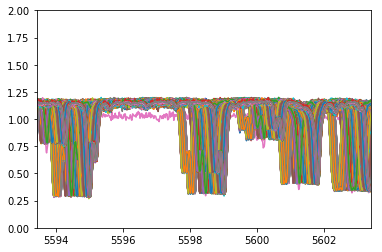

In [4]:
spectra = []

for isot in list(archive): 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)
    
    if sp.flux.max() < 1.2:
        plt.plot(sp.wavelength, sp.flux)

tio = 5598.410

plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [5]:
dx = []
for i in range(1, len(spectra)):
    cross_corr = np.correlate(spectra[0].flux - np.median(spectra[0].flux), 
                              spectra[i].flux - np.median(spectra[i].flux), mode='same')
    
    dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())
#     print(cross_corr.shape[0]//2 - cross_corr.argmax())

(0, 2)

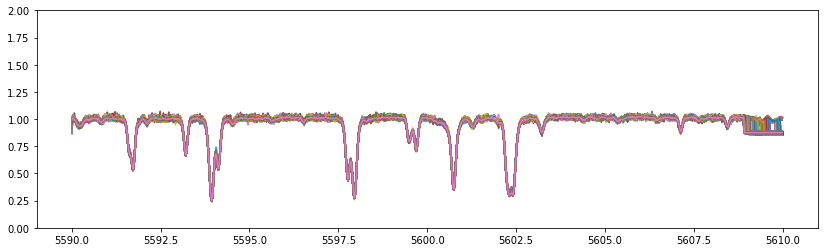

In [6]:
coadded = spectra[0].flux

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))
plt.figure(figsize=(14, 4))
for i in range(1, len(spectra)): 
    if spectra[i].flux.max() < 1.2:

        wavelength_shift = dx[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(spectra[0].wavelength, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        plt.plot(spectra[i].wavelength, rolled_spectrum)
        coadded += rolled_spectrum

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [7]:
from phoenix import get_any_metallicity_url, get_phoenix_model_wavelengths
from astropy.io import fits

In [8]:
phoenix_wl = get_phoenix_model_wavelengths()
phoenix_fl = fits.getdata(get_any_metallicity_url(5800, 4.5, 0))
phoenix_fl /= phoenix_fl.max()

phoenix_fl = phoenix_fl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]
phoenix_wl = phoenix_wl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]

phoenix_fl /= np.median(phoenix_fl)

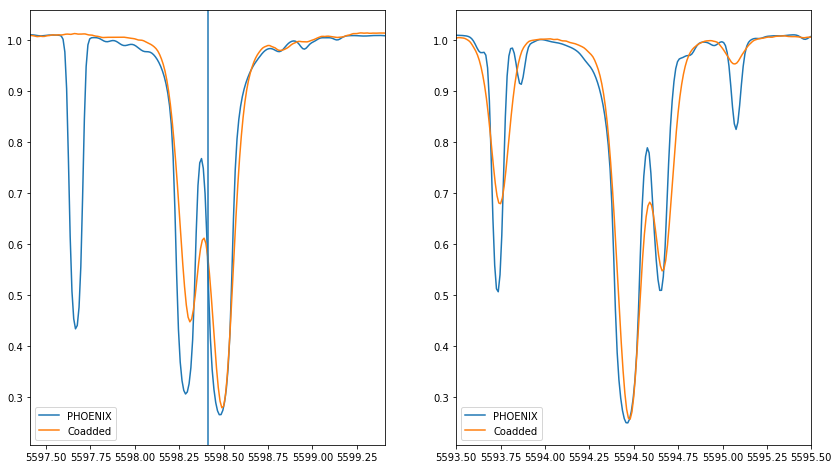

In [95]:
wavelength_offset = -0.54 #1.42
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].plot(phoenix_wl, phoenix_fl, label='PHOENIX')
ax[0].plot(spectra[0].wavelength - wavelength_offset, coadded, label='Coadded')
window = 1.
ax[0].set_xlim([tio - window, tio + window])
ax[0].axvline(tio)
ax[0].legend()

control = 5594.5 #5593.75
ax[1].plot(phoenix_wl, phoenix_fl, label='PHOENIX')
ax[1].plot(spectra[0].wavelength - wavelength_offset, coadded, label='Coadded')
window = 1
ax[1].set_xlim([control - window, control + window])
ax[1].axvline(tio)
ax[1].legend()

In [10]:
from astropy.time import Time

In [11]:
dates = Time(list(archive), format='isot')

In [60]:
from json import load
f_S = load(open('f_S.json'))

In [62]:
plotdates = []
spot_coverages = []
for k, v in f_S.items():
    plotdates.append(Time(k, format='iso').plot_date)
    spot_coverages.append(v)

(0.18, 0.2)

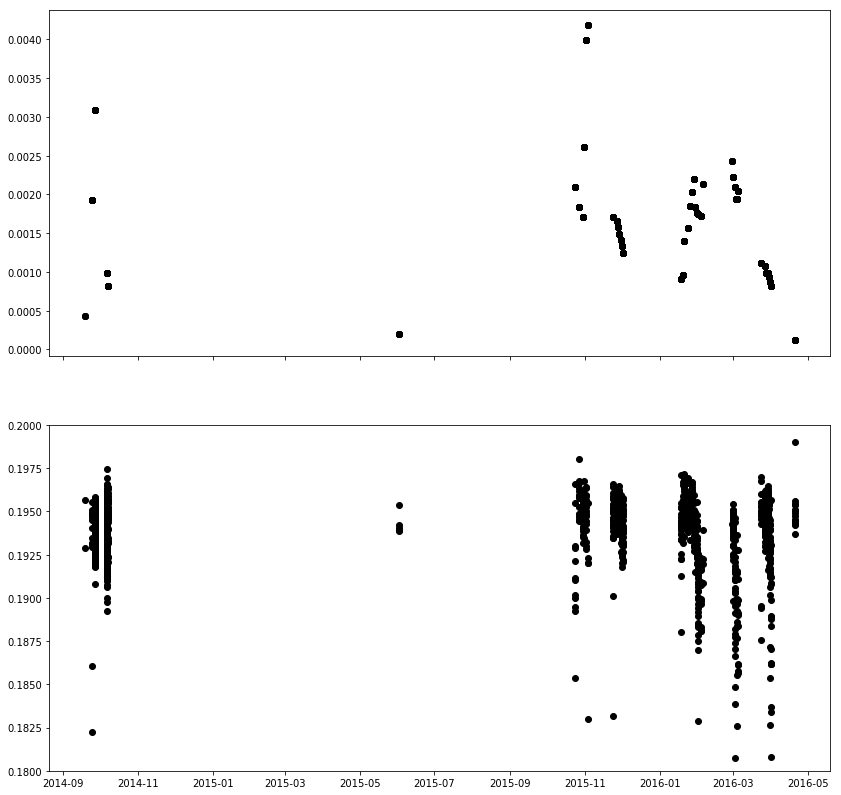

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

# fig2, ax2 = plt.subplots(figsize=(4, 4))

window = 1.  # 0.5

all_fs = []
all_ew = []

for i in range(1, len(spectra)):
    wavelength_shift = dx[i-1] * delta_wavelength

#     plt.plot(spectra[i].wavelength, coadded, color='k')
#     plt.plot(spectra[i].wavelength - wavelength_shift, spectra[i].flux / np.median(spectra[i].flux), color='k')
#     plt.show()
    interp = np.interp(spectra[0].wavelength, spectra[i].wavelength - wavelength_shift, 
                       spectra[i].flux / np.median(spectra[i].flux), left=1, right=1)
    
    offset_wavelengths = spectra[i].wavelength - wavelength_offset
#     plt.plot(offset_wavelengths[inrange], interp[inrange], alpha=0.01, color='k')
    
    inrange = ((offset_wavelengths < tio+window) & (offset_wavelengths > tio-window))
    
    eqwidth = np.trapz(1 - interp[inrange],  offset_wavelengths[inrange])
    
    date_key = str(dates[i-1].datetime.date())
    ax[0].plot_date(dates[i-1].plot_date, f_S[date_key], color='k')
    
    ax[1].plot_date(dates[i-1].plot_date, eqwidth, marker='o', color='k')
    
    
    all_fs.append(f_S[date_key])
    all_ew.append(eqwidth)
    
# plt.xlim([tio - window, tio + window])
#     plt.show()
#     ax[0].plot(spectra[0].wavelength - wavelength_offset, interp - coadded, color='k', alpha=0.01)
#     ax[1].plot(spectra[0].wavelength - wavelength_offset, interp - coadded, color='k', alpha=0.01)
#     plt.show()

# window = 1
# ax[0].set_xlim([tio - window, tio + window])

# tiolines = [5598.390, 5598.400, 5598.410, 5598.421, 5598.432]

# for tioline in tiolines: 
#     ax[0].axvline(tioline, ls='--', alpha=0.5)
    
# ax[1].set_ylim([0.18, 0.194])
ax[1].set_ylim([0.18, 0.2])
# plt.axhline(0.2)
# window = 1
# ax[1].set_xlim([control - window, control + window])

# plt.xlim(Time(['2016-01-17', '2016-02-06'], format='iso').plot_date)

# ax[0].set_xlim(Time(['2016-01-17', '2016-02-02'], format='iso').plot_date)
# plt.xlim(Time(['2014-09-26 16:45', '2014-09-26 17:00'], format='iso').plot_date)

# ax[1].set_ylim([-0.02, 0.02])

(0, 0.005)

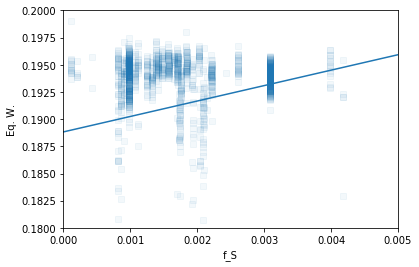

In [98]:
plt.scatter(all_fs, all_ew, marker=',', alpha=0.05)

params = np.polyfit(all_fs, all_ew, 1)
x = np.linspace(0, 0.005)
y = np.polyval(params, x)

plt.plot(x, y)
plt.xlabel('f_S')
plt.ylabel('Eq. W.')
plt.ylim([0.18, 0.2])
plt.xlim([0, 0.005])